In [78]:
import os
import zipfile
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
sns.set_theme()

In [56]:
path_initial_simp = "/Users/me/software-configuration-problem/cpp-approach/experiments/run_initial_heuristic/01_output"
path_initial_nosimp = "/Users/me/software-configuration-problem/cpp-approach/experiments/run_initial_no_simplification/01_output"

In [84]:
simp_data = []
with open(path_initial_simp + "/output.jsonl", "rb") as f:
    for line in f:
        line = line.decode('utf-8')
        line_data = json.loads(line)
        first_sol_time = 72000.0
        for event in line_data["events"]:
            if event['type'] == 'FIRST_SOLVE_DONE':
                first_sol_time = event['time']
                break
        simp_stats = line_data['simplification']['simplification_stats']
        simp_data.append({
            "instance_name": line_data["instance_name"],
            "first_solution_time": first_sol_time,
            "variables_before": simp_stats["variables_before"],
            "variables_after": simp_stats["variables_after"],
            "formula_length_before": simp_stats["formula_length_before"],
            "formula_length_after": simp_stats["formula_length_after"],
            "concrete_after": simp_stats["concrete_after"],
            "concrete_before": simp_stats["concrete_before"]
        })

In [57]:
nosimp_data = []
with open(path_initial_nosimp + "/output.jsonl", "rb") as f:
    for line in f:
        line = line.decode('utf-8')
        line_data = json.loads(line)
        first_sol_time = 72000.0
        for event in line_data["events"]:
            if event['type'] == 'FIRST_SOLVE_DONE':
                first_sol_time = event['time']
                break
        nosimp_data.append({"instance_name": line_data["instance_name"],
                            "first_solution_time_nosimp": first_sol_time})

In [85]:
df_simp = pd.DataFrame(simp_data)
df_simp

,instance_name,first_solution_time,variables_before,variables_after,formula_length_before,formula_length_after,concrete_after,concrete_before
0,busybox-2007-03-24_15-37-57,0.010588,422,411,1839,854,411,421
1,busybox-2009-11-23_06-20-09,0.015662,607,580,2689,1205,580,606
2,busybox-2017-07-15_17-34-33,0.024247,828,790,4155,1991,790,827
3,busybox-2008-02-19_23-42-22,0.013897,547,532,2350,1091,532,546
4,busybox-2007-03-09_16-56-38,0.010299,417,406,1795,842,406,416
...,...,...,...,...,...,...,...,...
957,busybox-2010-01-31_18-12-57,0.016666,619,590,2750,1225,590,618
958,uclibc-2016-11-27_16-35-32,0.022701,238,210,3832,1112,210,237
959,fiasco-2018-08-20_14-36-18,0.037418,235,187,3898,1837,187,234
960,uclibc-2009-08-01_01-40-34,0.029776,238,216,5129,1699,216,237


In [86]:
df_nosimp = pd.DataFrame(nosimp_data)
df_nosimp

,instance_name,first_solution_time_nosimp
0,soletta-2015-08-21_13-54-55,0.007212
1,busybox-2008-02-15_15-17-23,0.012200
2,busybox-2009-10-09_22-11-30,0.015245
3,busybox-2008-10-13_08-53-43,0.013745
4,busybox-2007-06-21_12-41-59,0.010293
...,...,...
957,busybox-2008-04-13_22-41-27,0.012797
958,soletta-2015-11-03_18-43-35,0.009035
959,busybox-2008-11-06_23-42-42,0.013452
960,busybox-2007-06-20_15-23-03,0.010201


In [87]:
data = pd.DataFrame(df_simp.merge(df_nosimp, left_on="instance_name", right_on="instance_name"))

In [88]:
data.reset_index(inplace=True, drop=True)

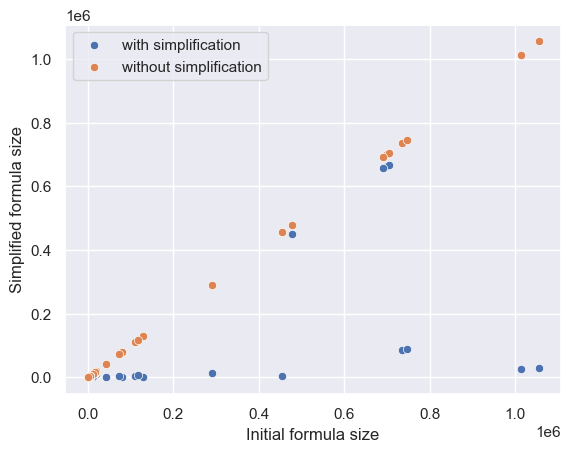

In [89]:
sns.scatterplot(data=data, x="formula_length_before", y="formula_length_after", label="with simplification")
sns.scatterplot(data=data, x="formula_length_before", y="formula_length_before", label="without simplification")
plt.gca().set_xlabel("Initial formula size")
plt.gca().set_ylabel("Simplified formula size")
plt.savefig("simplification_formula_size.pdf", bbox_inches="tight")

In [116]:
subprocess.run(["open", "."])

CompletedProcess(args=['open', '.'], returncode=0)

In [97]:
data["formula_reduction"] = 100 * data["formula_length_after"] / data["formula_length_before"]

In [98]:
data["variable_reduction"] = 100 * data["variables_after"] / data["variables_before"]

In [99]:
data["concrete_reduction"] = 100 * data["concrete_after"] / data["concrete_before"]

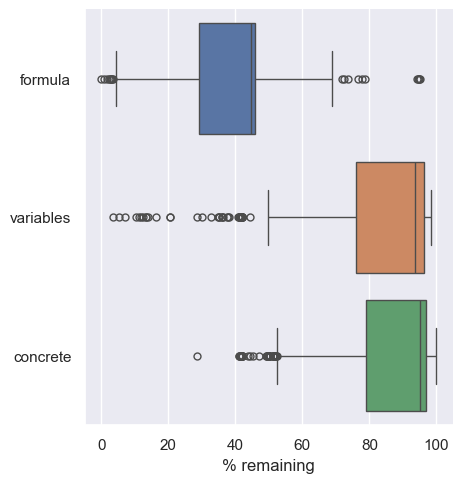

In [111]:
reductions = []
for row in data.itertuples():
    reductions.append({"instance_name": row.instance_name, "reduction_type": "formula",
                       "remaining_pct": row.formula_reduction})
    reductions.append({"instance_name": row.instance_name, "reduction_type": "variables",
                       "remaining_pct": row.variable_reduction})
    reductions.append({"instance_name": row.instance_name, "reduction_type": "concrete",
                       "remaining_pct": row.concrete_reduction})

sns.catplot(data=pd.DataFrame(reductions), x="remaining_pct", y="reduction_type", kind="box",
            hue="reduction_type")
plt.gca().set_xlabel("% remaining")
plt.gca().set_ylabel("")
plt.savefig("simplification_types.pdf", bbox_inches="tight")